In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
'''
3) Real-life dataset
'''

df = pd.read_csv('./Datasets/communities.csv', header=None)
df[0] = 1
df.drop([i for i in range(1, 5)], axis=1, inplace=True) # These columns are not predictive according to the dataset
df.columns = [i for i in range(df.shape[1])] # Rename columns
df = df.replace('?', np.NaN).astype(np.float64)

print(df.head())

   0     1     2     3     4     5     6     7     8     9    ...    114  \
0  1.0  0.19  0.33  0.02  0.90  0.12  0.17  0.34  0.47  0.29  ...   0.12   
1  1.0  0.00  0.16  0.12  0.74  0.45  0.07  0.26  0.59  0.35  ...   0.02   
2  1.0  0.00  0.42  0.49  0.56  0.17  0.04  0.39  0.47  0.28  ...   0.01   
3  1.0  0.04  0.77  1.00  0.08  0.12  0.10  0.51  0.50  0.34  ...   0.02   
4  1.0  0.01  0.55  0.02  0.95  0.09  0.05  0.38  0.38  0.23  ...   0.04   

    115   116   117   118  119  120   121   122   123  
0  0.26  0.20  0.06  0.04  0.9  0.5  0.32  0.14  0.20  
1  0.12  0.45   NaN   NaN  NaN  NaN  0.00   NaN  0.67  
2  0.21  0.02   NaN   NaN  NaN  NaN  0.00   NaN  0.43  
3  0.39  0.28   NaN   NaN  NaN  NaN  0.00   NaN  0.12  
4  0.09  0.02   NaN   NaN  NaN  NaN  0.00   NaN  0.03  

[5 rows x 124 columns]


In [3]:
'''
Part 1) Fill in missing values 
'''
df.fillna(df.mean(), inplace=True)
# print(df.columns[df.isnull().any()].tolist())

N_examples = df.shape[0]
M_cols = df.shape[1]
df = df.sample(frac=1) # This shuffles the examples
data = np.array(df, dtype=np.float64)

print(df.head())

      0     1     2     3     4     5     6     7     8     9    ...    114  \
425   1.0  0.01  0.49  0.09  0.85  0.10  0.13  0.43  0.53  0.33  ...   0.01   
1309  1.0  0.10  0.37  0.02  0.97  0.04  0.07  0.26  0.30  0.17  ...   0.31   
1747  1.0  0.14  0.60  0.14  0.69  0.23  0.28  0.41  0.55  0.31  ...   0.26   
563   1.0  0.04  0.33  0.33  0.73  0.02  0.01  0.47  0.50  0.42  ...   0.07   
93    1.0  0.00  0.49  0.01  0.94  0.14  0.04  0.47  0.42  0.27  ...   0.00   

       115   116       117       118       119       120  121       122   123  
425   0.26  0.02  0.163103  0.076708  0.698589  0.440439  0.0  0.195078  0.16  
1309  0.06  0.02  0.163103  0.076708  0.698589  0.440439  0.0  0.195078  0.13  
1747  0.09  0.06  0.163103  0.076708  0.698589  0.440439  0.0  0.195078  0.50  
563   0.13  0.00  0.163103  0.076708  0.698589  0.440439  0.0  0.195078  0.25  
93    0.35  0.20  0.163103  0.076708  0.698589  0.440439  0.0  0.195078  0.12  

[5 rows x 124 columns]


In [4]:
'''
Part 2) Fit data and report 5-fold cross-validation error
'''
# Normal equation with regularization (lambda_reg=0 means no regularization)
def fit(X, y, lambda_reg=0):
    identity = np.identity(X.shape[1])
    # identity[0, 0] = 0 # We do not penalize the bias term

    X_square = np.matmul(np.transpose(X), X) + lambda_reg * identity
    X_square_inverse = np.linalg.pinv(X_square)
    weights = np.matmul(np.matmul(X_square_inverse, np.transpose(X)), y)

    return weights

# Gradient descent
def gradient_descent(X, y, lambda_reg=0, alpha=1e-2, epochs=5000, weights=None):
    '''
    Implementation of vectorized gradient descent with L2 regularization support
    :param X: The input matrix N x M, where each row is an example
    :param y: The output, N x 1
    :param lambda_reg: Regularization hyperparamter (0 means no regularization)
    :param alpha: Learning rate
    :param epochs: Number of cycles over training data
    :param weights: Initial weights can be supplied if desired
    :return: The optimal weights after gradient descent
    '''
    weights = weights if weights is not None else np.random.uniform(high=10, size=[M_cols - 1])
    N = len(X)
    for epoch in range(epochs):
        weights = weights - alpha / N * ( np.matmul(np.transpose(X), np.matmul(X, weights) - y) + lambda_reg * weights)

    return weights

def mean_square_error(X, y, W):
    y_hat = np.matmul(X, W)
    mean_square_err = np.sum(np.square(y - y_hat)) / len(y)

    return mean_square_err


def cross_validation_split(X, n_folds=5, filename="file", write_to_csv=False):
    '''
    Splits the dataset intn n_folds
    :param X: The input matrix, N x M
    :param n_folds: The number of folds
    :param filename: The output file prefix
    :param write_to_csv: True if saving each fold required
    :return: An array of dictionaries of length n_folds
    '''
    N = len(X) // n_folds
    pairs = []
    for i in range(n_folds):
        fold_train1 = X[0:i * N]
        if i < n_folds - 1:
            fold_test = X[i*N:(i+1)*N]
            fold_train2 = X[(i+1)*N:]
        else:
            fold_test = X[i*N:]
            fold_train2 = X[N:N]

        df_train = pd.DataFrame(np.concatenate((fold_train1, fold_train2)))
        df_test = pd.DataFrame(fold_test)

        if write_to_csv:
            df_train.to_csv('./Datasets/' + filename + '-train' + str(i + 1) + '.csv', header=False, index=False)
            df_test.to_csv('./Datasets/' + filename + '-test' + str(i + 1) + '.csv', header=False, index=False)

        pairs.append({'train': df_train, 'test': df_test})

    return pairs


def write_to_csv(to_df_object, filename, indexname=None):
    df_to_csv = pd.DataFrame(to_df_object)
    if indexname:
        df_to_csv.index.name = indexname
    df_to_csv.to_csv(filename + '.csv')


In [5]:
# Generate the files for 5-fold cross-validation
# splits = [{'train':<train_data>, 'test': <test_data>}, {'train':<train_data>, 'test': <test_data>}, {'train':<train_data>, 'test': <test_data>}\
# {'train':<train_data>, 'test': <test_data>}, {'train':<train_data>, 'test': <test_data>}]
splits = cross_validation_split(data, 5, 'CandC', False)

In [6]:
MSEs_closed_form = []
all_weights = {}
fold = 1
for pair in splits:
    X_train = pair['train'].drop([M_cols - 1], axis=1)
    y_train = pair['train'][M_cols-1]
    X_test = pair['test'].drop([M_cols - 1], axis=1)
    y_test = pair['test'][M_cols - 1]

    weights = fit(X_train, y_train)
    MSEs_closed_form.append(mean_square_error(X_test, y_test, weights))
    all_weights['fold' + str(fold)] = weights
    fold += 1
    

In [7]:
MSEs_gd = []
all_weights_gd = {}
weights = np.random.uniform(high=10., size=[M_cols - 1])
fold = 1
for pair in splits:
    X_train = pair['train'].drop([M_cols - 1], axis=1)
    y_train = pair['train'][M_cols - 1]
    X_test = pair['test'].drop([M_cols - 1], axis=1)
    y_test = pair['test'][M_cols - 1]

    weights_gd = gradient_descent(np.array(X_train), np.array(y_train), epochs=20000, weights=np.copy(weights))
    MSEs_gd.append(mean_square_error(X_test, y_test, weights_gd))
    all_weights_gd['fold' + str(fold)] = weights_gd
    fold += 1


In [9]:
print('least squares:', np.average(MSEs_closed_form))
print('gradient descent:', np.average(MSEs_gd))


least squares: 0.27297450166938364
gradient descent: 0.5878188923244896


In [10]:
# The assignment wants us to store all these weights so the TAs can look over them.
# Write weights to file (weight_index refers to w0, w1, etc. The weights for each fold are represented as columns in the csv. There are 5 columns and 123 rows)
write_to_csv(all_weights, 'q3_part2_weights_for_closed_form', 'weight_index')
write_to_csv(all_weights_gd, 'q3_part2_weights_for_gradient_descent', 'weight_index')


In [11]:
'''
Part 3) Ridge-regression: Using only least-squares closed form solution for this part.
'''
INCREMENTS = 100
MSE_vs_lambda = []
lambdas = np.arange(0, 5, 5 / INCREMENTS)
lowest_mse = 999999
best_lambda = -1

for lambda_value in lambdas:
    cur_mse = 0
    weights_for_folds = {}
    fold = 0
    for pair in splits:
        X_train = pair['train'].drop([M_cols - 1], axis=1)
        y_train = pair['train'][M_cols - 1]
        X_test = pair['test'].drop([M_cols - 1], axis=1)
        y_test = pair['test'][M_cols - 1]

        weights = fit(X_train, y_train, lambda_value)
        cur_mse += mean_square_error(X_test, y_test, weights)
        weights_for_folds['fold' + str(fold)] = weights

    cur_mse /= len(splits)
    if cur_mse < lowest_mse:
        lowest_mse = cur_mse
        best_lambda = lambda_value

    MSE_vs_lambda.append(cur_mse)
    write_to_csv(weights_for_folds, './question3part3/weights_lambda_' + str(lambda_value), 'weight_index')

print('Best lambda:', best_lambda)
print('MSE for best lambda:', lowest_mse)

for i in range(len(MSE_vs_lambda)):
    print('MSE for lambda =', lambdas[i], 'is', MSE_vs_lambda[i])


Best lambda: 1.4000000000000001
MSE for best lambda: 0.018568358777022342
MSE for lambda = 0.0 is 0.27297450166938364
MSE for lambda = 0.05 is 0.018999415091165435
MSE for lambda = 0.1 is 0.01887441111271968
MSE for lambda = 0.15000000000000002 is 0.01880203759202171
MSE for lambda = 0.2 is 0.01875359100671354
MSE for lambda = 0.25 is 0.018718458808259363
MSE for lambda = 0.30000000000000004 is 0.018691667370246367
MSE for lambda = 0.35000000000000003 is 0.01867053166312279
MSE for lambda = 0.4 is 0.018653455409163147
MSE for lambda = 0.45 is 0.018639419677155204
MSE for lambda = 0.5 is 0.018627737331107196
MSE for lambda = 0.55 is 0.018617924263636742
MSE for lambda = 0.6000000000000001 is 0.018609627062205678
MSE for lambda = 0.65 is 0.018602580047813837
MSE for lambda = 0.7000000000000001 is 0.018596578548643213
MSE for lambda = 0.75 is 0.01859146160724642
MSE for lambda = 0.8 is 0.018587100407000585
MSE for lambda = 0.8500000000000001 is 0.018583390295462805
MSE for lambda = 0.9 is

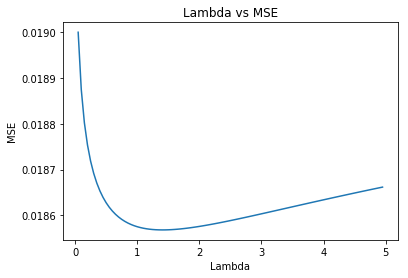

In [12]:
plt.figure(1)
plt.plot(lambdas[1:], MSE_vs_lambda[1:])
plt.title('Lambda vs MSE')
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.savefig('./plots/q3p31',  bbox_inches='tight')
plt.show()


In [13]:
# Feature selection
# If a feature's associated weight is close to zero, it means that it contributes less to the prediction.
# These features are good candidates for being excluded from the model.
# We can first sort the weights and see which ones contribute the least to prediction
all_weights_feature_selection = {}
fold = 1
for pair in splits:
    X_train = pair['train'].drop([M_cols - 1], axis=1)
    y_train = pair['train'][M_cols - 1]
    X_test = pair['test'].drop([M_cols - 1], axis=1)
    y_test = pair['test'][M_cols - 1]

    weights = fit(X_train, y_train, lambda_reg=best_lambda) # Regularization with best_lambda from above
    all_weights_feature_selection['fold' + str(fold)] = weights
    fold += 1


In [14]:
# Now we look for weights that are close to zero in the regularized fit
features_to_drop = set()
for key in all_weights_feature_selection:
    w = all_weights_feature_selection[key]
    # This basically converts the weight vector [w0, w1...] to [(0, w0), (1, w1),...] so after we sort the weights we know which features they correspond to
    all_weights_feature_selection[key] = [(i, abs(w[i])) for i in range(len(w))]
    all_weights_feature_selection[key].sort(key=lambda x: x[1])
    [features_to_drop.add(x[0]) for x in all_weights_feature_selection[key][:20]]

for val in all_weights_feature_selection.values():
    print(val)

[(33, 0.0007658155985651137), (42, 0.0016334976077323961), (85, 0.002505190700459072), (119, 0.0025253638833119887), (36, 0.0027566131826181174), (67, 0.0038340661876292595), (21, 0.00538546464701382), (106, 0.005793980744495397), (97, 0.006059135062247073), (1, 0.006154077358450845), (118, 0.0065423607511759995), (53, 0.0070431642216821164), (56, 0.00791573095796599), (96, 0.009239222348098947), (20, 0.009464008902608479), (54, 0.010062298047947388), (28, 0.010144100139110507), (77, 0.010189363784573637), (82, 0.010244727184217272), (122, 0.01120187889305321), (58, 0.011225968724213118), (13, 0.011230909571080479), (108, 0.01211335987778007), (23, 0.013158690819599727), (98, 0.014273672865324764), (107, 0.01436820350509616), (61, 0.01499613869317994), (94, 0.015075070819671507), (104, 0.015363790356780262), (79, 0.015502461981422248), (27, 0.015621571418281013), (57, 0.016404121753609485), (115, 0.016469430394339804), (32, 0.0166616001349634), (121, 0.017398879874157815), (71, 0.01822

In [52]:
MSEs_final = []
all_weights_final = {}
fold = 1
for pair in splits:
    X_train = pair['train'].drop([M_cols - 1], axis=1)
    y_train = pair['train'][M_cols-1]
    X_test = pair['test'].drop([M_cols - 1], axis=1)
    y_test = pair['test'][M_cols - 1]

    # Drop the features we found to have near 0 coefficients
    X_train.drop(list(features_to_drop), axis=1, inplace=True)
    X_test.drop(list(features_to_drop), axis=1, inplace=True)

    weights = fit(X_train, y_train, lambda_reg=best_lambda)
    MSEs_final.append(mean_square_error(X_test, y_test, weights))
    all_weights_final['fold' + str(fold)] = weights
    fold += 1

print('Number of features to be dropped:', len(features_to_drop))
print('Best lambda:', best_lambda)
print('MSE for best lambda:', lowest_mse)
print('MSE for best lambda after dropping least contributing features:', np.average(MSEs_final))


Number of features to be dropped: 51
Best lambda: 1.4500000000000002
MSE for best lambda: 0.01840859569971876
MSE for best lambda after dropping least contributing features: 0.01791864486507244
